In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from colorama import Fore, Style

In [24]:
clusters = pd.read_csv('data/clustering.csv')
mnist = pd.read_csv('data/MNIST_dataset.csv')

## Base

No hay mucho que ver en los datos, se puede interpretear bastante claramente a simple vista. <br>
Saco la columna redundante de los indices de fila, y g rafico A vs B a ver si me dice algo (en MNIST no hago nada en principio)

In [25]:
# Base Process
clusters = clusters.drop("Unnamed: 0", axis=1)

In [26]:
# Print clusters preview
print(Fore.CYAN + "clusters DataFrame Preview:" + Style.RESET_ALL)
print(clusters.head(n=15))

clusters DataFrame Preview:
         A       B
0   812954  643720
1   868217  609046
2   920248  607272
3   841621  639394
4   843907  598777
5   817712  620917
6   865980  632292
7   876539  639944
8   805247  642901
9   829227  565484
10  834679  669557
11  851242  630615
12  890325  702688
13  832159  638667
14  833736  637738


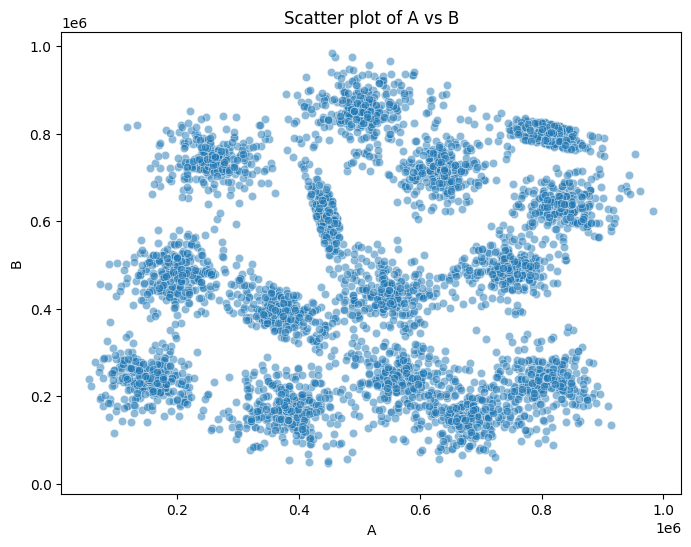

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=clusters, x='A', y='B', alpha=0.5)
plt.title('Scatter plot of A vs B')
plt.xlabel('A')
plt.ylabel('B')
plt.show()

Se pueden ver varios clusters claros, tambien se puede ver que los valores son muy grandes. Para estabilidad numerica, los puedo dividir a todos por una constante luego de ver sus rangos
<br> Si tuviera que decir alguna adivinanza inicial, supongo que 14-16 clusters podrian verse

In [28]:
# Veo sus rangos
summary = {
    'A_lowest': clusters['A'].nsmallest(5).values,
    'A_highest': clusters['A'].nlargest(5).values,
    'B_lowest': clusters['B'].nsmallest(5).values,
    'B_highest': clusters['B'].nlargest(5).values
}
summary_table = pd.DataFrame(summary)
print(Fore.YELLOW + "5 lowest and 5 highest values for each column in clusters:" + Style.RESET_ALL)
print(summary_table)

5 lowest and 5 highest values for each column in clusters:
   A_lowest  A_highest  B_lowest  B_highest
0     55608     983609     25631     984555
1     58050     961248     30810     975112
2     64731     954037     47368     974808
3     70828     945668     50189     965047
4     72179     944095     53060     956802


Con estos valores, puedo dividir por 10,000 por ejemplo

In [48]:
# Normalization
clust_df = clusters.astype(np.float32) / 10_000
clust = clust_df.values

In [50]:
# Pandas Magic para visualizar que todo salio bien
clust_preview = pd.DataFrame(clust[:15], columns=clust_df.columns)
separator = pd.DataFrame([['', '']] * 15, columns=['xd', 'xd'])

clust_preview_rounded = clust_preview.round(4).map(lambda x: f"{x:.4f}")
clust_df_rounded = clust_df.head(15).reset_index(drop=True).round(4).map(lambda x: f"{x:.4f}")

full_table = pd.concat([clust_preview_rounded, separator, clust_df_rounded, separator, clusters.head(15).reset_index(drop=True)], axis=1)
full_table.columns = ['clust_A', 'clust_B', '', '', 'clust_df_A', 'clust_df_B', '', '', 'clusters_A', 'clusters_B']
print(full_table.to_string(index=False))

clust_A clust_B   clust_df_A clust_df_B    clusters_A  clusters_B
81.2954 64.3720      81.2954    64.3720        812954      643720
86.8217 60.9046      86.8217    60.9046        868217      609046
92.0248 60.7272      92.0248    60.7272        920248      607272
84.1621 63.9394      84.1621    63.9394        841621      639394
84.3907 59.8777      84.3907    59.8777        843907      598777
81.7712 62.0917      81.7712    62.0917        817712      620917
86.5980 63.2292      86.5980    63.2292        865980      632292
87.6539 63.9944      87.6539    63.9944        876539      639944
80.5247 64.2901      80.5247    64.2901        805247      642901
82.9227 56.5484      82.9227    56.5484        829227      565484
83.4679 66.9557      83.4679    66.9557        834679      669557
85.1242 63.0615      85.1242    63.0615        851242      630615
89.0325 70.2688      89.0325    70.2688        890325      702688
83.2159 63.8667      83.2159    63.8667        832159      638667
83.3736 63

Con el procesamiento de datos finalizado, empiezo el trabajo

In [87]:
import importlib
import utils
import cupy as cp
importlib.reload(utils)
X_cp = cp.asarray(clust)

# 1)

Testeo que funcione una call

In [90]:
Ks = range(1, 30)
L_dists = []
cp.random.seed(42)

for K in Ks:
    labels_cp, centroids_cp = utils.kmeans(X=X_cp, K=K, max_iters=1000, rel_tol=1e-15, abs_tol=1e-13)
    L = utils.compute_L(X_cp, labels_cp, centroids_cp)
    L_dists.append(L)

K-Means (K=29):   3%|▎         | 26/1000 [00:00<00:12, 76.51iter/s]


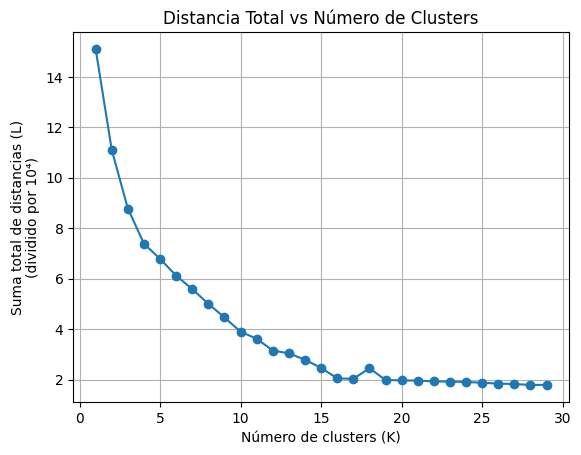

In [91]:
plt.plot(Ks, np.array(L_dists) / 1e4, marker='o')
plt.xlabel("Número de clusters (K)")
plt.ylabel("Suma total de distancias (L)\n(dividido por 10⁴)")
plt.title("Distancia Total vs Número de Clusters")
plt.grid(True)
plt.show()

Aca ya puedo ver unas diminishing gains claras (como era de esperar). Quizas irse hasta mas que la 16 podria ser demasiado lejos, pero ya puedo ir poniendo si o si un limite mental ahi.<br>Claramente antes de la 8 seria perderse demasiado tambien. Podria ser en la 16 quizas, sino tambien la 12, o la 10 incluso aunque quizas muy poco

In [75]:
print(Style.BRIGHT + "K vs L_dist with ΔL and % Drop:" + Style.RESET_ALL)
print(f"{'K':>2} | {'L':>12} | {'ΔL':>12} | {'% Drop':>8}")
print("-" * 42)

for i, (k, l) in enumerate(zip(Ks, L_dists)):
    if i == 0:
        print(f"{k:2d} | {l:12.2f} | {'—':>12} | {'—':>8}")
    else:
        diff = L_dists[i - 1] - l
        percentage = 100 * diff / L_dists[i - 1]
        print(f"{k:2d} | {l:12.2f} | {diff:12.2f} | {percentage:7.2f}%")


K vs L_dist with ΔL and % Drop:
 K |            L |           ΔL |   % Drop
------------------------------------------
 1 |    151047.09 |            — |        —
 2 |    111026.53 |     40020.56 |   26.50%
 3 |     89418.62 |     21607.91 |   19.46%
 4 |     73857.54 |     15561.09 |   17.40%
 5 |     66318.27 |      7539.27 |   10.21%
 6 |     60463.79 |      5854.48 |    8.83%
 7 |     56418.10 |      4045.69 |    6.69%
 8 |     49417.57 |      7000.53 |   12.41%
 9 |     45415.17 |      4002.39 |    8.10%
10 |     39464.44 |      5950.73 |   13.10%
11 |     37562.57 |      1901.87 |    4.82%
12 |     34383.17 |      3179.39 |    8.46%
13 |     26623.07 |      7760.10 |   22.57%
14 |     26511.25 |       111.82 |    0.42%
15 |     23921.53 |      2589.72 |    9.77%
16 |     24940.59 |     -1019.05 |   -4.26%
17 |     20307.82 |      4632.77 |   18.58%
18 |     20012.48 |       295.34 |    1.45%
19 |     19855.87 |       156.61 |    0.78%
20 |     19671.21 |       184.65 |    0.93%
2

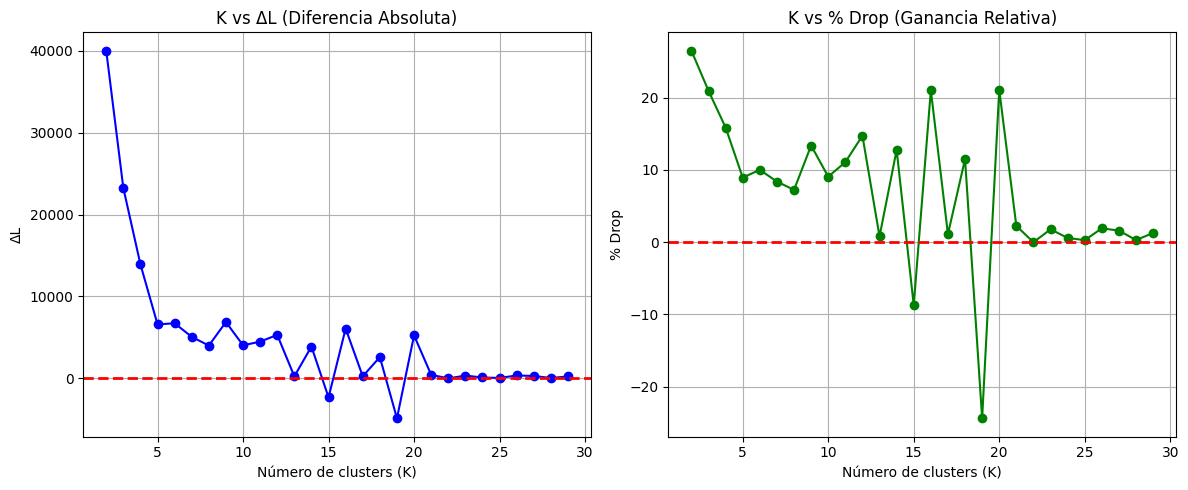

In [73]:
diff_L = [None] + [L_dists[i - 1] - L_dists[i] for i in range(1, len(L_dists))]
pct_drop = [None] + [100 * (L_dists[i - 1] - L_dists[i]) / L_dists[i - 1] for i in range(1, len(L_dists))]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# K vs ΔL
ax1.plot(Ks[1:], diff_L[1:], marker='o', color='blue')
ax1.axhline(0, color='red', linestyle='--', linewidth=2)
ax1.set_title("K vs ΔL (Diferencia Absoluta)")
ax1.set_xlabel("Número de clusters (K)")
ax1.set_ylabel("ΔL")
ax1.grid(True)

# K vs % Drop
ax2.plot(Ks[1:], pct_drop[1:], marker='o', color='green')
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_title("K vs % Drop (Ganancia Relativa)")
ax2.set_xlabel("Número de clusters (K)")
ax2.set_ylabel("% Drop")
ax2.grid(True)

plt.tight_layout()
plt.show()

Creo que en base a estos resultados, voy con...

# elegi, either k=13, k=15, o k=17